## A project on Customer Segmentation by: **Pranav Raj**

## Introduction

Customer segmentation is important for businesses to understand their target audience. 

Different advertisements can be curated and sent to different audience segments based on their demographic profile, interests, and affluence level.

A segment based approach can be taken to improve the business.

# Importing libraries 

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from kneed import KneeLocator
from sklearn.datasets import make_blobs

#K-Means and Silhouette score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#Standardisation
from sklearn.preprocessing import StandardScaler

#PCA
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

#Warnings
import warnings
warnings.filterwarnings("ignore")

# Dendogram and Linkage
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage

# Agglomorerative Hierarchical Clustering
import sklearn
from sklearn.cluster import AgglomerativeClustering

## Importing and reading the dataset

In [2]:
data = pd.read_csv("/Users/pranavsmac/Documents/Praxis Study Materials/Dataset/Mall_Customers.csv")
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Here we have a dataset which comprises observations of different customers which might have visited recently to that mall.

In [3]:
data.shape

(200, 5)

In [4]:
data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

* Luckily we have no *Null* observations.

* There are five variables in the dataset.

* CustomerID is the unique identifier for each customer in the dataset. We can drop this variable since it does not provide any useful cluster information.

* Since gender is categorical, it needs to be encoded and converted into numeric.

* All other variables meeds to be scaled down to follow.a normal distribution before being fitted into the model. We will standardise these variables with a mean of 0 and standard deviation of 1.

In [5]:
data = data.drop(['CustomerID'], axis = 1)

In [6]:
data.tail()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
195,Female,35,120,79
196,Female,45,126,28
197,Male,32,126,74
198,Male,32,137,18
199,Male,30,137,83


# EDA

In [30]:
data.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [41]:
def Graph(data, columns = '', directory = os.getcwd()):
    
    try:                     #to catch exceptions
        if columns == '':                #If no columns mentioned, considers all columns
            org_data = data
        else:
            org_data = data[columns]           #Takes mentioned columns only
        
        Numerical = []
        Categorical = []
        for columns in data:
            if (data.dtypes[columns] == 'int64') or (data.dtypes[columns] == 'float64'):         #Numerical columns
                Numerical.append(columns)
            else:
                Categorical.append(columns)       #categorical columns

        print ("***Graphs for Numerical data***\n")
        Discrete = []
        Continuous = []
        for i in Numerical:
            if len(data[i].value_counts())>10:         # Unique counts greater than 10 considered as continuous
                print ("***Graph for Continuous data***\n")
                data.boxplot(column = i,grid = True,figsize = (6,4),vert = True)  #boxplot
                data.hist(column = i,grid = False,figsize = (6,4),color = "turquoise",edgecolor = "purple")   #histogram
                plt.title(i, fontsize = 14)
                #plt.savefig(directory + r'/%s.png' %i)       #saving as '.png' image in the given directory
                plt.show()
            else:                    #10 and less unique counts considered as discrete
                print ("***Graph for Discrete data***\n")
                data[i].value_counts().plot(kind = 'bar',rot=0, figsize = (10,10),color = "pink",edgecolor = "red",fontsize = 13)       #barplot
                plt.title(i, fontsize = 14)
                #plt.savefig(directory + r'/%s.png' %i)
                plt.show()


        print ("\n***Graphs for Categorical data***\n")
        for i in Categorical or len(data[i].value_counts())<10:
            data[i].value_counts().plot(kind = 'bar',rot=0, figsize = (5,5),color = "orange",edgecolor = "maroon",fontsize = 13)       #barplot
            plt.ylabel('count')
            plt.title(i, fontsize = 14)
            #plt.savefig(directory + r'/%s.png' %i)
            plt.show()
    #error handling
    except KeyError:                                        
        print("\nPlease Enter valid column names")
    except FileNotFoundError:                              
        print("\nFile not found. Please enter the valid path of directory")
    except:
        print("\nERROR") 

***Graphs for Numerical data***

***Graph for Continuous data***



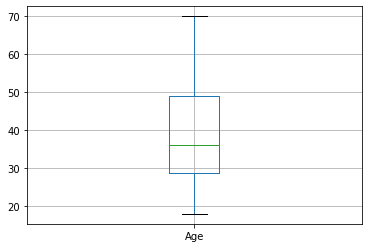

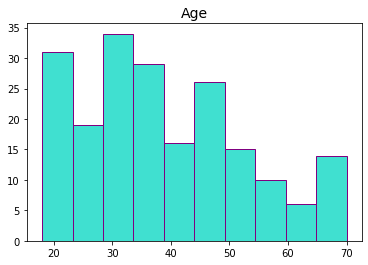

***Graph for Continuous data***



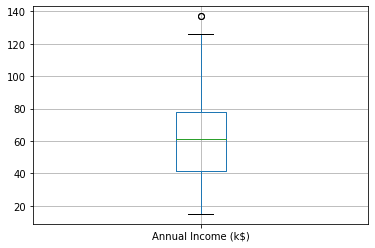

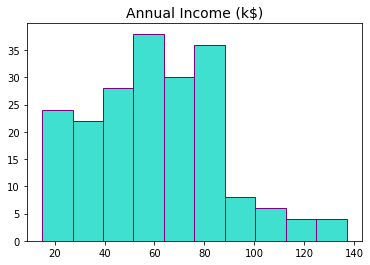

***Graph for Continuous data***



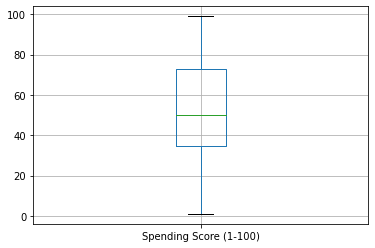

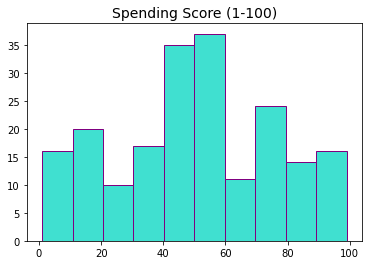


***Graphs for Categorical data***



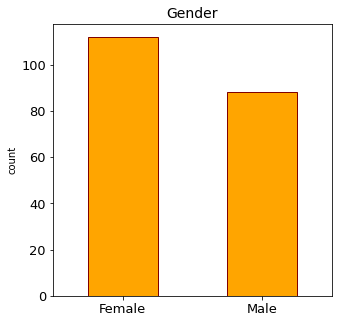

In [42]:
Graph(data, columns = '', directory = "/Users/pranavsmac/Documents/Praxis Study Materials/Dataset/")

* We can see that customers age has a median of 36.

* It can be observed that even senior citizens consists of 25% of customers, which is quite a surprise since the normal intuition would be senior citizens won't shop much.

* There is a dense concentration on customers ranging from 20-36 yrs. of age, which consists of 50% of observations. 

* Annual Income and Spending score seems collinear, which might be true, since people who are earning will have a spending score accordingly.

# Standardizing variables

Scaling the variables is important, to get all the variables around the same scale.

In [45]:
col = ['Annual Income (k$)', 'Age', 'Spending Score (1-100)']
features = data[col]
scaler = StandardScaler().fit(features.values)
features = scaler. transform(features.values)
scaled_features = pd.DataFrame(features, columns = col)
scaled_features.head()

,Annual Income (k$),Age,Spending Score (1-100)
0,-1.738999,-1.424569,-0.434801
1,-1.738999,-1.281035,1.195704
2,-1.700830,-1.352802,-1.715913
3,-1.700830,-1.137502,1.040418
4,-1.662660,-0.563369,-0.395980


We can observe that the variables have been standardised and are now centered around zero.

# One hot encoding

* Since gender is categorical, it needs to be encoded and converted into numeric.

* This means we need to assign a numeric value for each category using dummy variables. Dummy variables works under pandas library using pd.get_dummies().

In [46]:
gender = data['Gender']
new_data = scaled_features.join(gender)

new_data = pd.get_dummies(new_data, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)   #one hot encoding

new_data = new_data.drop(['Gender_Male'],axis=1)    #to get just female columns, the observations with zeroes in them are considered as male and 1 means female.

new_data.head()

,Annual Income (k$),Age,Spending Score (1-100),Gender_Female
0,-1.738999,-1.424569,-0.434801,0
1,-1.738999,-1.281035,1.195704,0
2,-1.700830,-1.352802,-1.715913,1
3,-1.700830,-1.137502,1.040418,1
4,-1.662660,-0.563369,-0.395980,1


# Dendrogram and Linkage

    The linkage methods work by calculating the distances or similarities between all objects.

### *Complete Linkage*

    For two clusters R and S, the complete linkage returns the maximum distance between two points i and j such that i belongs to R and j belongs to S.


In [9]:
#Initialising 'Z' for checking Complete Linkage on 'new_data'
Z = linkage(new_data, "complete")           

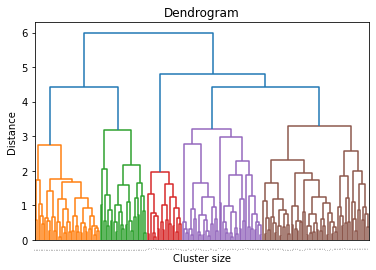

In [10]:
#plotting Dendrogram for clustering
dendrogram(Z, leaf_rotation=90, leaf_font_size=1.)
plt.title("Dendrogram")
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.show()

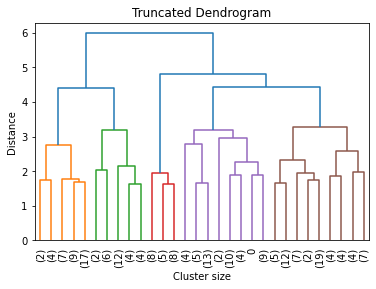

In [11]:
#truncating dendrogram for a cleaner view
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90, leaf_font_size=10.)
plt.title("Truncated Dendrogram")
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.show()

A clustering of 3-5 segments of customers can be done using *complete linkage*.

Clustering of 5 segments seems optimal.

### *Average Linkage*

    For two clusters R and S, first for the distance between any data-point i in R and any data-point j in S and then the arithmetic mean of these distances are calculated. Average Linkage returns this value of the arithmetic mean.


In [12]:
#Initialising 'Z' for checking Complete Linkage on 'new_data'
Z = linkage(new_data, "average")

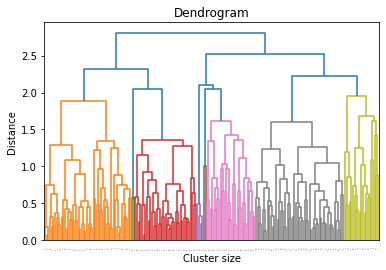

In [13]:
#plotting Dendrogram for clustering
dendrogram(Z, leaf_rotation=90, leaf_font_size=1.)
plt.title("Dendrogram")
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.show()

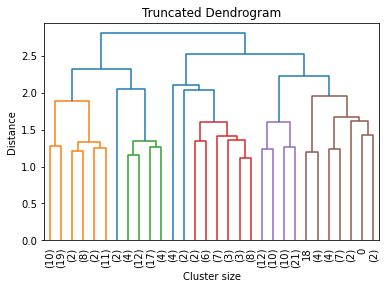

In [14]:
#truncating dendrogram for a cleaner view
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90, leaf_font_size=10.)
plt.title("Truncated Dendrogram")
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.show()

A clustering of 4-8 segments of customers can be done using *average linkage*.

### *Single Linkage*

    For two clusters R and S, the single linkage returns the minimum distance between two points i and j such that i belongs to R and j belongs to S.

In [15]:
#Initialising 'Z' for checking Complete Linkage on 'new_data'
Z = linkage(new_data, "single")

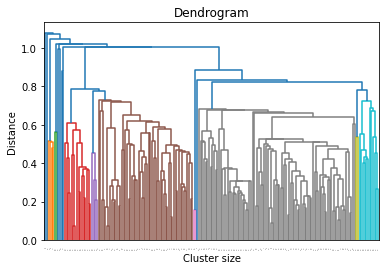

In [16]:
#plotting Dendrogram for clustering
dendrogram(Z, leaf_rotation=90, leaf_font_size=1.)
plt.title("Dendrogram")
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.show()

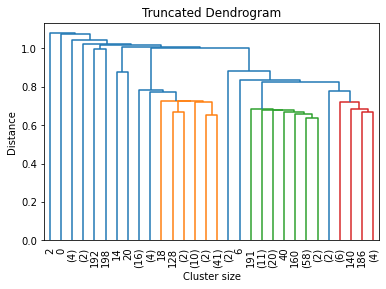

In [17]:
#truncating dendrogram for a cleaner view
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90, leaf_font_size=10.)
plt.title("Truncated Dendrogram")
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.show()

Clustering among customers is not possible with *single linkage*, as it is giving a very complicated Dendrogram.

# **Model Fitting**

## Model 1
### Agglomerative Hierarchical Clustering

    - It is also known as bottom-up approach or hierarchical agglomerative clustering (HAC).
    - This algorithm considers each dataset as a single cluster at the beginning, and then start combining the closest pair of clusters together. It does this until all the clusters are merged into a single cluster that contains all the datasets.
    - This hierarchy of clusters is represented in the form of the dendrogram.

### * Using Euclidean distance

In [51]:
#Clustering taken for 5 segments, as obtained from Complete Linkage Dendrogram.
hclust = AgglomerativeClustering(n_clusters = 5, affinity='euclidean', linkage = 'complete')

In [52]:
hclust.fit(new_data)

AgglomerativeClustering(linkage='complete', n_clusters=5)

In [53]:
#Grouping Data
hclust.labels_

array([1, 2, 1, 2, 1, 2, 1, 2, 0, 2, 0, 2, 0, 2, 0, 2, 1, 2, 0, 2, 0, 2,
       0, 2, 0, 2, 0, 1, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 1,
       0, 2, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 4, 1, 4, 0, 4, 3, 4, 3, 4,
       1, 4, 1, 4, 3, 4, 1, 4, 3, 4, 1, 4, 1, 4, 0, 4, 3, 4, 3, 4, 3, 4,
       3, 4, 3, 4, 3, 4, 0, 4, 1, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4,
       3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4,
       3, 4])

In [54]:
data['Groups'] = hclust.labels_
data.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),Groups
0,Male,19,15,39,1
1,Male,21,15,81,2
2,Female,20,16,6,1
3,Female,23,16,77,2
4,Female,31,17,40,1


In [55]:
# Checking the aggregate of the groups
hac_euc = data.groupby(['Groups']).mean()
hac_euc

,Age,Annual Income (k$),Spending Score (1-100)
Groups,,,
0,54.078125,47.968750,40.609375
1,26.750000,53.604167,43.458333
2,24.809524,25.619048,80.238095
3,43.892857,91.285714,16.678571
4,32.692308,86.538462,82.128205


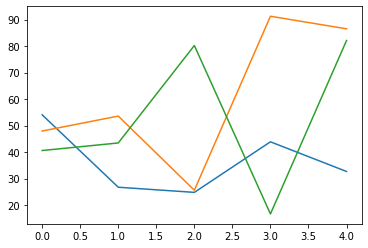

In [56]:
plt.plot(hac_euc)
plt.show()

* Silhouette coefficient:
    
        A silhouette coefficient, or a silhouette score is a metric used to evaluate the quality of clusters created by the algorithm.

        Silhouette scores range from -1 to +1. The higher the silhouette score, the better the model.

        The silhouette score measures the distance between all the data points within the same cluster. The lower this distance, the better the silhouette score.

        It also measures the distance between an object and the data points in the nearest cluster. The higher this distance, the better.

        A silhouette score closer to +1 indicates good clustering performance, and a silhouette score closer to -1 indicates a poor clustering model.

In [23]:
# Silhouette coefficient

# Building a model with 5 clusters as obtained from Complete Linkage Dendrogram..

aglo = AgglomerativeClustering(n_clusters = 5, affinity='euclidean', linkage = 'complete')
aglo.fit(new_data)

# Now, print the silhouette score of this model

print(silhouette_score(new_data, aglo.labels_, metric='euclidean'))

0.3404764937897312


The Silhouette score obtained by this model is 0.34. Its not a bad score but lets try to improve it.

### * Using Cossine similarity

In [47]:
#Clustering taken for 5 segments, as obtained from Complete Linkage Dendrogram.
hclust = AgglomerativeClustering(n_clusters = 4, affinity='cosine', linkage = 'complete')

In [48]:
hclust.fit(new_data)

AgglomerativeClustering(affinity='cosine', linkage='complete', n_clusters=4)

In [49]:
#Grouping Data
hclust.labels_

array([3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0,
       3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 1, 0, 3, 0,
       3, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 3, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 3, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 2, 0,
       0, 0, 2, 0, 1, 0, 2, 0, 1, 0, 0, 0, 2, 0, 1, 0, 2, 0, 2, 0, 1, 0,
       1, 0, 2, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2, 0, 2, 0, 2, 0, 2, 0, 1, 0,
       1, 0, 1, 0, 2, 0, 2, 0, 2, 0, 1, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0])

In [50]:
data['Groups'] = hclust.labels_
data.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),Groups
0,Male,19,15,39,3
1,Male,21,15,81,0
2,Female,20,16,6,3
3,Female,23,16,77,0
4,Female,31,17,40,3


In [51]:
# Checking the aggregate of the groups
hac_cosine = data.groupby(['Groups']).mean()
hac_cosine

,Age,Annual Income (k$),Spending Score (1-100)
Groups,,,
0,28.744898,61.632653,69.061224
1,55.636364,60.109091,42.800000
2,36.130435,91.391304,16.652174
3,44.250000,27.666667,22.291667


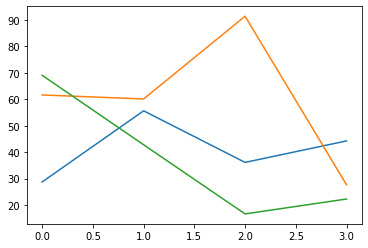

In [52]:
plt.plot(hac_cosine)
plt.show()

In [53]:
# Silhouette coefficient

# Building a model with 5 clusters as obtained from Complete Linkage Dendrogram..

aglo = AgglomerativeClustering(n_clusters = 5, affinity='cosine', linkage = 'complete')
aglo.fit(new_data)

# Now, print the silhouette score of this model

print(silhouette_score(new_data, aglo.labels_, metric='euclidean'))

0.31547941765644727


* Since, the more the silhouette score the better. Therefore, we will continue to use Euclidean Distance for clustering.

## Model 2
### K-Means Clustering
    
    - K-Means Clustering is an unsupervised learning algorithm.
    - It groups the unlabeled dataset into different clusters. Here K defines the number of pre-defined clusters that need to be created in the process, as if K=2, there will be two clusters, and for K=3, there will be three clusters, and so on.
    -It allows us to cluster the data into different groups and a convenient way to discover the categories of groups in the unlabeled dataset on its own without the need for any training.
    -It is a centroid-based algorithm, where each cluster is associated with a centroid. The main aim of this algorithm is to minimize the sum of distances between the data point and their corresponding clusters.

Text(0, 0.5, 'Inertia')

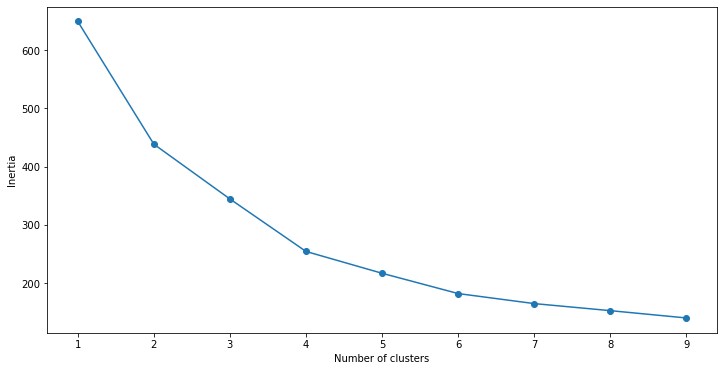

In [24]:
SSE = []

for cluster in range(1,10):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(new_data)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them

frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

* The optimal number of clusters seems to be 4.

In [25]:
# Building a model with 4 clusters since we got the optimal number of clusters at 4.

kmeans = KMeans(n_jobs = -1, n_clusters = 4, init='k-means++')
kmeans.fit(new_data)

# Now, print the silhouette score of this model

print(silhouette_score(new_data, kmeans.labels_, metric='euclidean'))

0.35027020434653977


* The Silhouette score obtained by this model is 0.35. A slightly better score can be seen when compared to Agglomorerative Clustering(0.34).

* Little improvement in the model.

## Model 3
### Prinipal Component Analysis and K-Means

* PCA is a technique that helps us reduce the dimension of a dataset. When we run PCA on a data frame, new components are created. These components explain the maximum variance in the model.

* We can select a subset of these variables and include them into the K-means model.

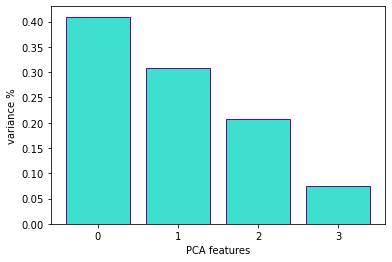

In [27]:
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(new_data)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='Turquoise', edgecolor = "purple")
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

PCA_components = pd.DataFrame(principalComponents)

This chart shows us each PCA component, along with it variance.

Based on this visualization, we can see that the first two PCA components explain around 70% of the dataset variance.

We can feed these two components into the model.

Lets build the model again with the first two principal components, and decide on the number of clusters to use.

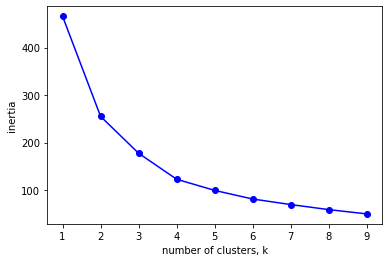

In [28]:
ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(PCA_components.iloc[:,:2])
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='blue')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

* It looks like optimal number of clusters is 4, again.

In [30]:
model = KMeans(n_clusters=4)
model.fit(PCA_components.iloc[:,:2])

# silhouette score
print(silhouette_score(PCA_components.iloc[:,:2], model.labels_, metric='euclidean')) 

0.42177622653948804


* The silhouette score for model 3 is 0.42, which is best score yet, compared to previous models.

* Best performing model.

# Cluster Analysis

In [31]:
data = pd.read_csv("/Users/pranavsmac/Documents/Jupyter Notebook/Dataset/Mall_Customers.csv")
data = data.drop(['CustomerID'],axis=1)

# map back clusters to dataframe

pred = model.predict(PCA_components.iloc[:,:2])
frame = pd.DataFrame(data)
frame['cluster'] = pred
frame.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,Male,19,15,39,0
1,Male,21,15,81,0
2,Female,20,16,6,3
3,Female,23,16,77,0
4,Female,31,17,40,0


* Notice that each row in the data frame is now assigned to a cluster.

In [32]:
# Now, to compare attributes of the different clusters, 
#lets find the average of all variables across each cluster.
avg_data = data.groupby(['cluster'], as_index=False).mean()
avg_data

,cluster,Age,Annual Income (k$),Spending Score (1-100)
0,0,25.605263,32.631579,67.500000
1,1,41.685714,88.228571,17.285714
2,2,30.000000,79.086207,70.775862
3,3,52.144928,46.333333,40.072464


Age vs Spending Score vs Annual Income


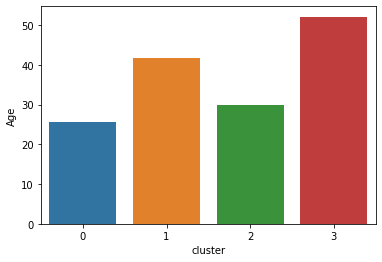

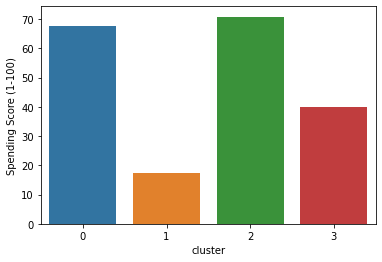

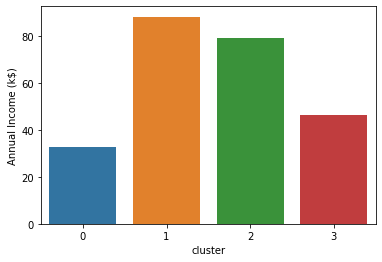

In [33]:
# Visualising clusters fpr interpreting it
print("Age vs Spending Score vs Annual Income")
sns.barplot(x='cluster',y='Age',data=avg_data)
plt.show()
sns.barplot(x='cluster',y='Spending Score (1-100)',data=avg_data)
plt.show()
sns.barplot(x='cluster',y='Annual Income (k$)',data=avg_data)
plt.show()

In [34]:
# Gender breakdown
data2 = pd.DataFrame(data.groupby(['cluster','Gender'])['Gender'].count())
data2

Gender
cluster Gender        
0       Female      23
        Male        15
1       Female      15
        Male        20
2       Female      34
        Male        24
3       Female      40
        Male        29

Cluster 0:

    Low average income, high spending score.

    Mean age is around 25 and gender is predominantly female.

    This segment is made up of a younger age group.

    Individuals in this segment are most likely first jobbers. They make the least amount of money compared to all other segments.

    However, they are very high spenders.

    These are enthusiastic young individuals who enjoy living a good lifestyle, and tend to spend above their means.

    Recommendation: Since these are young individuals who spend a lot, providing them with travel coupons or hotel discounts might be a good idea. Providing them with discounts off top clothing and makeup brands would also work well for this segment.

Cluster 1:

    High average annual income, low spending.

    Mean age is around 40 and gender is predominantly male.

    This segment comprises of middle aged individuals who are very careful with money.

    Despite having the highest average income compared to individuals in all other clusters, they spend the least.

    This might be because they have financial responsibilities - like saving up for their kid's higher education.

    Recommendation: Promos, coupons, and discount codes will attract individuals in this segment due to their tendency to spend less.

Cluster 2:

    High average income, high spending score.

    Mean age is around 30 and gender is predominantly female.

    This segment is made up of middle-aged individuals.

    These are individuals who have worked hard to build up a significant amount of wealth.

    They also spend large amounts of money to live a good lifestyle.

    These individuals have likely just started a family, and are leading baby or family-focused lifestyles. It is a good idea to promote baby or child related products to these individuals.

    Recommendation: Due to their large spending capacity and their demographic, these individuals are likely to be looking for properties to buy or invest in. They are also more likely than all other segments to take out housing loans and make serious financial commitments.

Cluster 3:

    Low to mid average income, average spending capacity.

    Mean age is around 50 and gender is predominantly female.

    This segment comprises of an older group of people.

    They earn less and spend less, and are probably saving up for retirement.

    Recommendation: Marketing to these individuals can be done through Facebook, which appeals to an older demographic. Promote healthcare related products to people in this segment.

# ***THE END***

                                   X----X----X